In [1]:
from DataSet import DataSet

Loading ml-1m data set...
Loading Success!
Data Info:
	User Num: 6040
	Item Num: 3952
	Data Size: 1000209


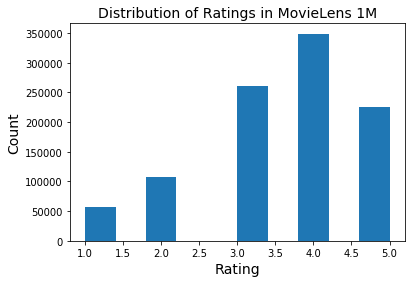

In [2]:
filepath = './Data/ml-1m/ratings.dat'
a = DataSet(filepath)

In [3]:
a.shape[0]

6040

In [3]:
import numpy as np
import pandas as pd


In [5]:
df = pd.DataFrame(a.data, columns=['user', 'item', 'ratings', 'time'])
df = df.drop(columns=['time'])

In [4]:
filename = './Data/ml-1m/u.data'
name = ['user', 'item', 'ratings', 'time']
df1 = pd.read_csv(filename, sep='\t', names = name)
df1 = df1.drop(columns=['time'])

In [5]:
data_dim = len(df1.user.unique()), len(df1.item.unique())

In [27]:
data_dim[0]

943

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
data = np.array(df1)
train, test = train_test_split(data, test_size=0.2)

In [8]:
u_train = train[:,0]
i_train = train[:,1]
r_train = train[:,2]
u_test = test[:,0]
i_test = test[:,1]
r_test = test[:,2]

In [6]:
shuffled_ratings = df.sample(frac = 1.)
Users = shuffled_ratings['user'].values
print ('Users:', Users, ', shape =', Users.shape)
Movies = shuffled_ratings['item'].values
print ('Movies:', Movies, ', shape =', Movies.shape)
Ratings = shuffled_ratings['ratings'].values
print ('Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [3646 5656 4051 ... 3453  662  659] , shape = (1000209,)
Movies: [2985  213 2797 ... 1294  410 2145] , shape = (1000209,)
Ratings: [4. 5. 2. ... 4. 4. 3.] , shape = (1000209,)


In [12]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import dot, concatenate, Embedding, Input, Flatten, Dropout, Dense,Conv1D
from keras.models import Sequential
from keras import optimizers

In [10]:
len_dim_i = [64,128,128,256,512]
len_dim_u = [64,128,128,256,512]
len_dim_r = [1024,512,512,256,256,128]

In [18]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

user_embedding = Embedding(output_dim=10, input_dim=data_dim[0] + 1,
                                   input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=10, input_dim=data_dim[1] + 1,
                                   input_length=1, name='item_embedding')(item_id_input)

user_vecs = (Dense(10))(user_embedding)
item_vecs = (Dense(10))(item_embedding)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
    

user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

    
# y = merge([user_vecs, item_vecs], mode='dot', output_shape=(1,))
y = dot([user_vecs, item_vecs], axes=1)
for i in range(len(len_dim_r)):
    y = (Dense(len_dim_r[i]))(y)
    y = (Dropout(0.2))(y)
# y = Dense(1, activation="relu")(y)
# M = Sequential()
# M.add(y)
y = (Dropout(0.2))(y)
y = (Dense(64))(y)
# y = (Dropout(0.2))(y)
y = (Dense(32))(y)
# y = (Dropout(0.2))(y)
# y = (Dense(16))(y)
# y = (Dropout(0.2))(y)
y = (Dense(4))(y)
y = (Dense(1, activation='relu'))(y)

model = Model(inputs=[user_id_input, item_id_input], outputs=[y])
adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='mae',metrics=['accuracy', 'mae'])

In [20]:
history = model.fit([u_train,i_train], r_train,validation_data=([u_test,i_test], r_test), batch_size=64, epochs = 5, verbose=1)

Train on 80000 samples, validate on 20000 samples
Epoch 1/5
80000/80000 [==============================] - 39s 493us/step - loss: 0.9632 - acc: 0.3171 - mean_absolute_error: 0.9632 - val_loss: 0.9036 - val_acc: 0.3367 - val_mean_absolute_error: 0.9036
Epoch 2/5
80000/80000 [==============================] - 41s 514us/step - loss: 0.9053 - acc: 0.3450 - mean_absolute_error: 0.9053 - val_loss: 0.8642 - val_acc: 0.3550 - val_mean_absolute_error: 0.8642
Epoch 3/5
80000/80000 [==============================] - 39s 490us/step - loss: 0.7828 - acc: 0.4101 - mean_absolute_error: 0.7828 - val_loss: 0.7900 - val_acc: 0.4029 - val_mean_absolute_error: 0.7900
Epoch 4/5
80000/80000 [==============================] - 41s 513us/step - loss: 0.7148 - acc: 0.4494 - mean_absolute_error: 0.7148 - val_loss: 0.7830 - val_acc: 0.4123 - val_mean_absolute_error: 0.7830
Epoch 5/5
80000/80000 [==============================] - 42s 520us/step - loss: 0.6839 - acc: 0.4701 - mean_absolute_error: 0.6839 - val_loss:

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        9440        user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        16830       item[0][0]                       
__________________________________________________________________________________________________
flatten_3 

In [11]:
# print(history)

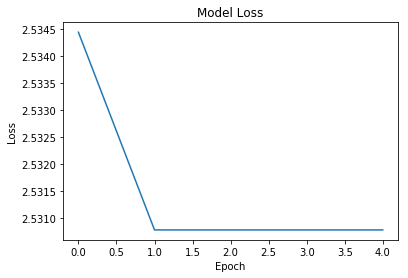

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

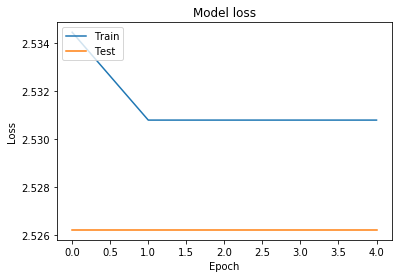

In [33]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
# history.history['acc']

In [14]:
# user_id_input = Input(shape=[1], name='user')
# item_id_input = Input(shape=[1], name='item')

# user_embedding = Embedding(output_dim=100, input_dim=a.shape[0] + 1,
#                                    input_length=1, name='user_embedding')(user_id_input)
# item_embedding = Embedding(output_dim=100, input_dim=a.shape[1] + 1,
#                                    input_length=1, name='item_embedding')(item_id_input)

# # reshape from shape: (batch_size, input_length, embedding_size)
# # to shape: (batch_size, input_length * embedding_size) which is
# # equal to shape: (batch_size, embedding_size)
# user_vecs = Flatten()(user_embedding)
# item_vecs = Flatten()(item_embedding)

#         # y = merge([user_vecs, item_vecs], mode='dot', output_shape=(1,))
# y = dot([user_vecs, item_vecs], axes=1)

# y = Dense

# model = Model(inputs=[user_id_input, item_id_input], outputs=[y])
# model.compile(optimizer='adam', loss='mae',metrics=['accuracy'])

In [15]:
# history = model.fit([Users,Movies], Ratings, batch_size=32, epochs = 5, verbose=1)

In [16]:
input_layer_u = Input(shape=[1], name='user')
input_layer_i = Input(shape=[1], name='item')
tower_u = Conv1D(filters=2,
                kernel_size=10,
                activation="tanh")(input_layer_u)
tower_i = Conv1D(filters=2,
                kernel_size=10,
                activation="tanh")(input_layer_i)
tower_u = MaxPooling1D()(tower_u)
tower_i = MaxPooling1D()(tower_i)
tower_u = Flatten()(tower_u)
tower_i = Flatten()(tower_i)
m = concatenate([tower_i,tower_u])
m = Dense(64, activation="relu")(m)
m = Dense(1,activation="relu")(m)
model = Model(inputs=[user_id_input, item_id_input], outputs=[m])
adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='mae',metrics=['accuracy', 'mae'])

ValueError: Input 0 is incompatible with layer conv1d_2: expected ndim=3, found ndim=2